In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
from evallm.enumerate_dfa.enumerate import unpack_dfa
from evallm.experiments.exhaustive_transducer_experiment import (
    exhaustive_gpt_4o_mini,
)
from evallm.experiments.render_dfa import render_pdfas

In [5]:
summary = {k: v[0] for k, v in exhaustive_gpt_4o_mini(1).items() if v[0] is not None}
pdfas = sorted(summary)

In [6]:
model_res_no_nan = [
    100
    * summary[pdfa].model_summary[1]
    / (summary[pdfa].model_summary[0] + summary[pdfa].model_summary[1])
    for pdfa in pdfas
]
model_res_nan_bad = np.array(
    [
        100 * summary[pdfa].model_summary[1] / sum(summary[pdfa].model_summary.values())
        for pdfa in pdfas
    ]
)
result_5gram = np.array([100 * summary[pdfa].ngram_each[5 - 1] for pdfa in pdfas])

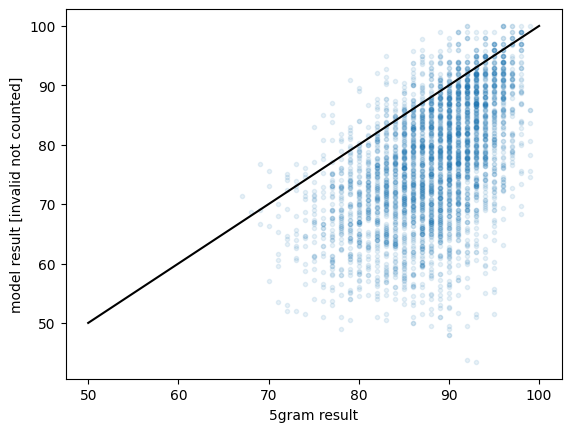

In [7]:
plt.scatter(result_5gram, model_res_no_nan, alpha=0.1, marker=".")
plt.plot([50, 100], [50, 100], color="black")
plt.xlabel("5gram result")
plt.ylabel("model result [invalid not counted]")
plt.show()

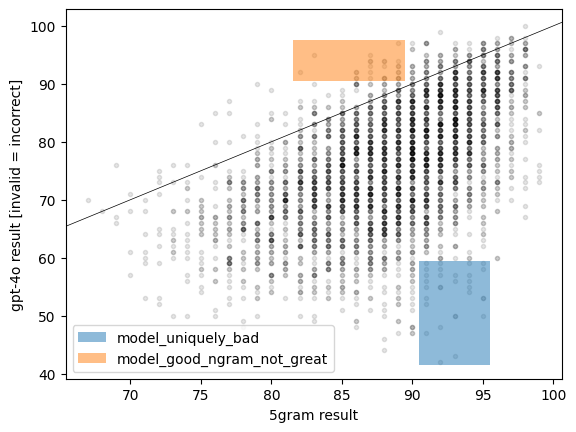

In [8]:
plt.scatter(result_5gram, model_res_nan_bad, alpha=0.1, marker=".", color="black")
xlim, ylim = plt.xlim(), plt.ylim()
plt.plot([50, 110], [50, 110], color="black", lw=0.5)
plt.xlabel("5gram result")
plt.ylabel("gpt-4o result [invalid = incorrect]")
masks = {
    "model_uniquely_bad": (result_5gram > 90) & (model_res_nan_bad < 60),
    "model_good_ngram_not_great": (result_5gram < 90) & (model_res_nan_bad > 90),
}
for label, mask in masks.items():
    plt.fill_between(
        [result_5gram[mask].min() - 0.5, result_5gram[mask].max() + 0.5],
        [model_res_nan_bad[mask].min() - 0.5] * 2,
        [model_res_nan_bad[mask].max() + 0.5] * 2,
        alpha=0.5,
        label=label,
    )
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.legend()
plt.show()

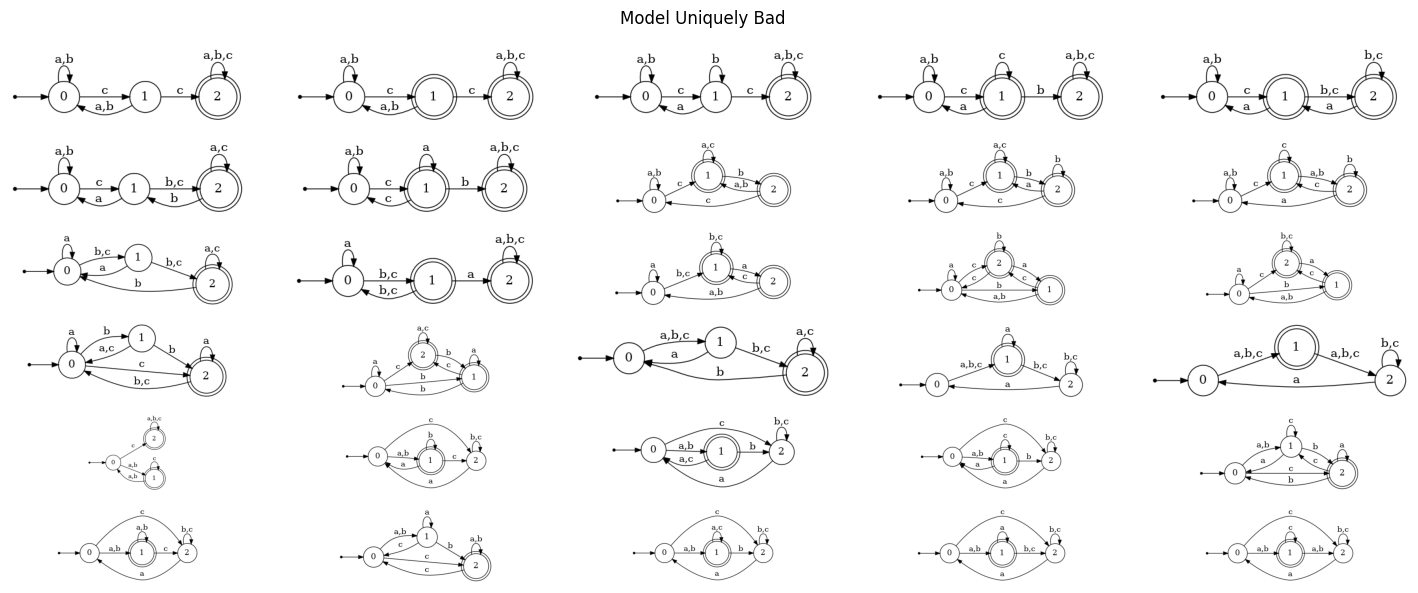

In [9]:
render_pdfas(
    [pdfas[i] for i in np.where(masks["model_uniquely_bad"])[0]], "Model Uniquely Bad"
)

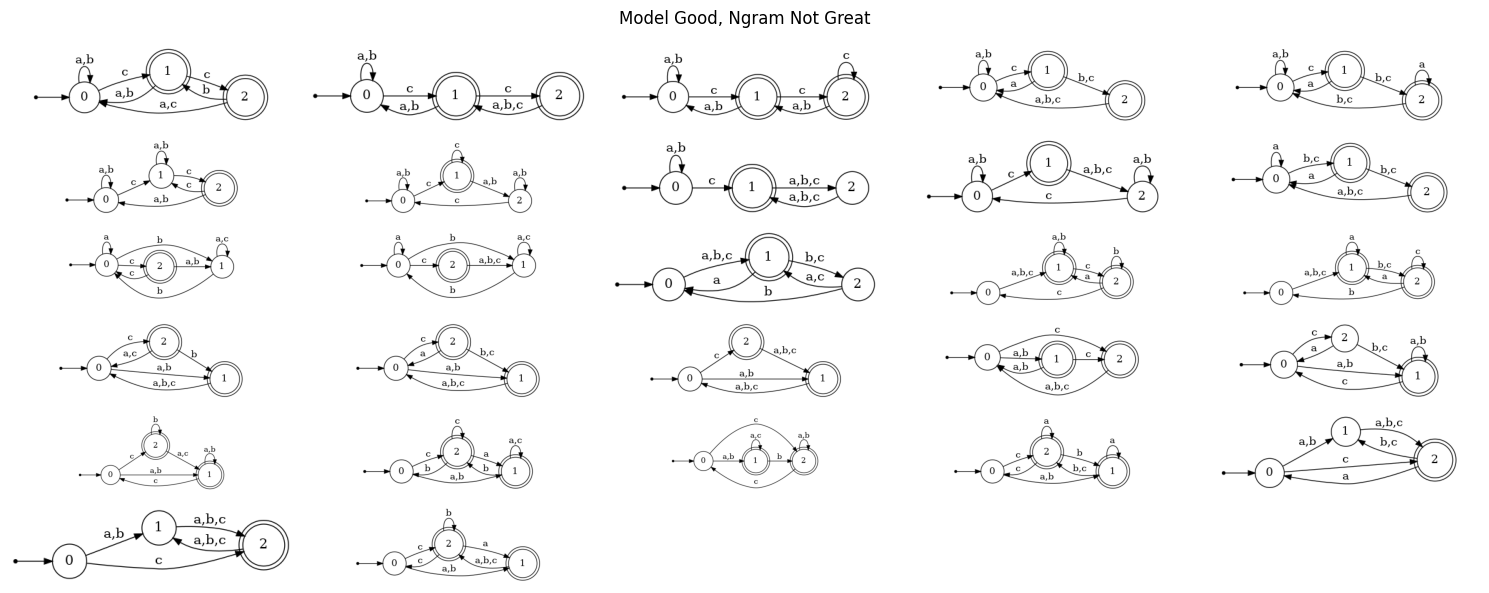

In [10]:
render_pdfas(
    [pdfas[i] for i in np.where(masks["model_good_ngram_not_great"])[0]],
    "Model Good, Ngram Not Great",
)